# Lesson 8 - Time Series

## Author - Dustin Burnham



## Instructions

Using the California dairy production dataset, perform time series analysis on the data for one of Cottage Cheese Production, Milk Production, or Ice Cream Production (your choice) to answer the following questions:

1. Is this time series stationary?
2. Is there a significant seasonal component?
3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

Then forecast production for 12 months and report both numeric values and plot the confidence intervals.

1. Are the confidence intervals reasonably small compared to the forecast means?
2. How do the confidence intervals behave as time moves to the future?


### Note
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

In [1]:
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/CADairyProduction.csv"

In [2]:
# Load necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss
import statsmodels.graphics.tsaplots as splt
import statsmodels.tsa.seasonal as sts
import numpy as np
import pandas as pd
import statsmodels.tsa.arima_process as arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMAResults  
import sklearn.linear_model as lm
from scipy.stats import zscore
import calendar
from datetime import datetime

In [3]:
dairy = pd.read_csv(fileName)

In [4]:
ice_cream = dairy[['Year', 'Month', 'Icecream.Prod']]

In [5]:
month_dict = {'Jan':'01', 'Feb':'02', 'Mar':'03', 'Apr':'04', 'May':'05', 'Jun':'06',
             'Jul':'07', 'Aug':'08', 'Sep':'09', 'Oct':'10', 'Nov':'11', 'Dec':'12'}

ice_cream['Month_Num'] = [month_dict[month] for month in ice_cream.loc[:,'Month']]

/Users/dusty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [6]:
ice_cream['Date'] = ice_cream['Year'].map(str) + '-' + ice_cream['Month_Num'].map(str)

/Users/dusty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
ice_cream = ice_cream[['Icecream.Prod']]
ice_cream.index = pd.date_range(start='1-1-1995', end='12-31-2013', freq = 'M')

In [8]:
ice_cream.head()

,Icecream.Prod
1995-01-31,51.595
1995-02-28,56.086
1995-03-31,68.453
1995-04-30,65.722
1995-05-31,73.730


# Part A:
### 1.  Is this time series stationary?

/Users/dusty/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Ice Cream Production over Time')

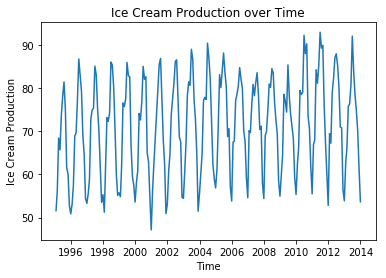

In [9]:
plt.plot(ice_cream['Icecream.Prod'])
plt.xlabel('Time')
plt.ylabel('Ice Cream Production')
plt.title('Ice Cream Production over Time')

In [10]:
def decomp_ts(ts, freq = 'M', model = 'additive'):
    res = sts.seasonal_decompose(ts, model = model) #, freq = freq)
    #resplot = res.plot()
    res.plot()
    return(res)

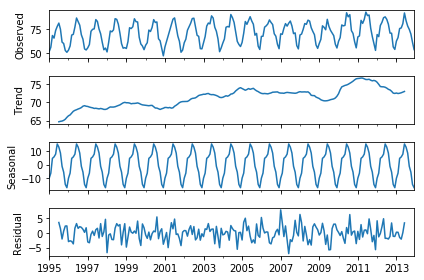

In [11]:
ice_cream_decomp = decomp_ts(ice_cream)

In [12]:
ice_cream_decomp = pd.DataFrame({'resid': ice_cream_decomp.resid['Icecream.Prod'],
                                'trend': ice_cream_decomp.trend['Icecream.Prod'],
                                'seasonal':ice_cream_decomp.seasonal['Icecream.Prod']})
                            

In [13]:
def DF_Test(ts):
    stationary = adfuller(ts)
    ## Print the results
    print('D-F statistic = ' + str(stationary[0]))
    print('p-value = ' + str(stationary[1]))
    print('number of lags used = ' + str(stationary[2]))
    print('Critical value at 5% confidence = ' + str(stationary[4]['5%']))
    print('Critical value at 10% confidence = ' + str(stationary[4]['10%']))
DF_Test(ice_cream_decomp.resid[6:-6])   

D-F statistic = -10.615314403551848
p-value = 5.694807144315272e-19
number of lags used = 9
Critical value at 5% confidence = -2.8756749365852587
Critical value at 10% confidence = -2.5743041549627677


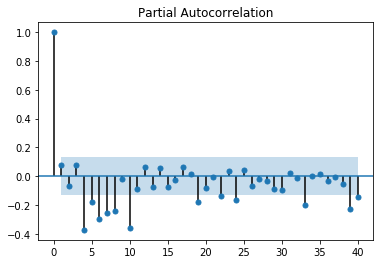

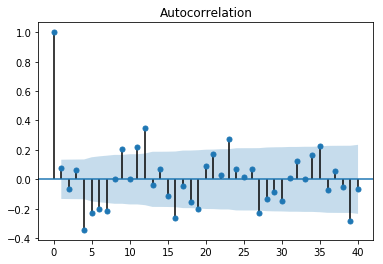

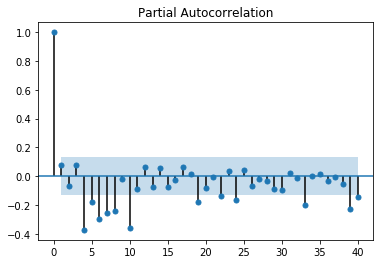

In [14]:
splt.plot_acf(ice_cream_decomp.resid[6:-6], lags = 40)
splt.plot_pacf(ice_cream_decomp.resid[6:-6], lags = 40)

### Results:

Yes this time series is stationary.  After running the DF test, the p-value was on the order of 10e-19, so we reject the null hypothesis that the time series is moving.

### 2.  Is there a significant seasonal component?
### Results:

Yes there is a significant seasonal component.  Every summer there is a rise in ice cream production (shocker).  In additionwe can still se some seasonal effects in the autocorrelation of the model.

### 3. For the residual from the STL decomposition of the time series, what is the order of the ARMA(p,q) process that best fits?

In [15]:
def model_ARIMA_2(ts, order):
    from statsmodels.tsa.arima_model import ARIMA
    from statsmodels.tsa.arima_model import ARIMAResults    
    model = ARIMA(ts, order = order)
    model_fit = model.fit(disp=0, method='mle', trend='nc')
    BIC = ARIMAResults.bic(model_fit)
    print('Testing model of order: ' + str(order) + ' with BIC = ' + str(BIC))
    return(BIC, order, model_fit)

def step_ARIMA(resid, p_max, d_max, q_max):
    from statsmodels.tsa.arima_model import ARIMAResults    
    from statsmodels.tsa.arima_model import ARIMA
    best_BIC = 9999999999999999.0
    for p in range(p_max + 1):
        for d in range(d_max + 1):
            for q in range(q_max + 1):
                if(p > 0 or q > 0):
                    try:
                        order = (p, d, q)
                        BIC, order, model = model_ARIMA_2(resid, order)
                        if(BIC < best_BIC):
                            best_model = model
                            best_BIC = BIC
                            best_order = order
                    except: 
                        pass        
    return(best_BIC, best_order, best_model) 

BIC, order, model = step_ARIMA(ice_cream_decomp.resid[6:-6], 3, 3, 3)    
print('***************************************')
print('Best model with BIC = ' + str(BIC) + ' and with order '+ str(order))

Testing model of order: (0, 0, 1) with BIC = 1033.948397930495
Testing model of order: (0, 0, 2) with BIC = 1015.4096856995327
Testing model of order: (0, 0, 3) with BIC = 1034.858687921396
Testing model of order: (0, 1, 1) with BIC = 1037.0797173287208
Testing model of order: (0, 1, 2) with BIC = 1040.738628211379
Testing model of order: (0, 1, 3) with BIC = 1041.2910465093016
Testing model of order: (0, 2, 1) with BIC = 1162.5649682550734
Testing model of order: (1, 0, 0) with BIC = 1034.1844707639355
Testing model of order: (1, 0, 1) with BIC = 1008.9611685072553
Testing model of order: (1, 0, 2) with BIC = 1001.0538922016856
Testing model of order: (1, 0, 3) with BIC = 1006.2497671967292
Testing model of order: (1, 1, 0) with BIC = 1119.6386241132811
Testing model of order: (1, 1, 1) with BIC = 1040.9889775823458
Testing model of order: (1, 2, 0) with BIC = 1285.100762137666
Testing model of order: (2, 0, 0) with BIC = 1038.4915705993046
Testing model of order: (2, 0, 1) with BIC =

In [16]:
BIC, order, model_fit = model_ARIMA_2(ice_cream_decomp.resid[6:-6], order = (3,0,3))

Testing model of order: (3, 0, 3) with BIC = 984.5822219930214


### Results:

The order of (3, 0, 3) create the model with the lowest BIC.

# Part B:
### 1.  Are the confidence intervals reasonably small compared to the forecast means?

## First I will find a good model for preditiction, then calculate 95% CI

### Try a linear model:
First I will make the months a dummy variable and then run a linear regression model to predict production.

In [17]:
dairy.head()

,Year,Month,Cotagecheese.Prod,Icecream.Prod,Milk.Prod,N.CA.Fat.Price,Month.Count,monthNumSqred,monthNumCubed
0,1995,Jan,4.370,51.595,2.112,0.9803,1,1,1
1,1995,Feb,3.695,56.086,1.932,0.8924,2,4,8
2,1995,Mar,4.538,68.453,2.162,0.8924,3,9,27
3,1995,Apr,4.280,65.722,2.130,0.8967,4,16,64
4,1995,May,4.470,73.730,2.227,0.8967,5,25,125


In [18]:
dairy['Month_Num'] = [month_dict[month] for month in dairy.loc[:,'Month']]
dairy['Date'] = dairy['Year'].map(str) + '-' + dairy['Month_Num'].map(str)
dairy = dairy[['Icecream.Prod', 'Month', 'Month.Count', 'monthNumSqred', 'monthNumCubed']]
dairy.index = pd.date_range(start='1-1-1995', end='12-31-2013', freq = 'M')

In [19]:
dairy = dairy[['Icecream.Prod', 'Month.Count', 'monthNumSqred', 'monthNumCubed', 'Month']]
dairy.index = pd.date_range(start='1-1-1995', end='12-31-2013', freq = 'M')
dairy.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed']] = dairy.loc[:, ['Month.Count', 'monthNumSqred', 'monthNumCubed']].apply(zscore)

In [20]:
years = int(len(dairy['Icecream.Prod'])/12)
dummies = pd.get_dummies(dairy.loc[:, 'Month'])
dairy[list(dummies.columns)] = dummies
## Print the head of the data frame to look at the dummy variables.
dairy.head(12)

,Icecream.Prod,Month.Count,monthNumSqred,monthNumCubed,Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
1995-01-31,51.595,-1.724471,-1.120740,-0.883649,Jan,0,0,0,0,1,0,0,0,0,0,0,0
1995-02-28,56.086,-1.709277,-1.120548,-0.883646,Feb,0,0,0,1,0,0,0,0,0,0,0,0
1995-03-31,68.453,-1.694084,-1.120226,-0.883641,Mar,0,0,0,0,0,0,0,1,0,0,0,0
1995-04-30,65.722,-1.678890,-1.119776,-0.883630,Apr,1,0,0,0,0,0,0,0,0,0,0,0
1995-05-31,73.730,-1.663696,-1.119198,-0.883612,May,0,0,0,0,0,0,0,0,1,0,0,0
1995-06-30,77.994,-1.648503,-1.118491,-0.883585,Jun,0,0,0,0,0,0,1,0,0,0,0,0
1995-07-31,81.475,-1.633309,-1.117656,-0.883547,Jul,0,0,0,0,0,1,0,0,0,0,0,0
1995-08-31,74.981,-1.618116,-1.116692,-0.883497,Aug,0,1,0,0,0,0,0,0,0,0,0,0
1995-09-30,61.530,-1.602922,-1.115600,-0.883433,Sep,0,0,0,0,0,0,0,0,0,0,0,1
1995-10-31,60.022,-1.587729,-1.114379,-0.883353,Oct,0,0,0,0,0,0,0,0,0,0,1,0


In [21]:
features = list(dairy.columns[1:])
features.pop(3)

'Month'

In [22]:
# Fit the moel
import sklearn.linear_model as lm
X = dairy.loc[:'2012-12-31', features].as_matrix()
Y = dairy.loc[:'2012-12-31', 'Icecream.Prod'].values
lm_mod = lm.LinearRegression(fit_intercept = False)
mod_fit = lm_mod.fit(X, Y)

/Users/dusty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
## and the predictions and the residual
dairy.loc[:'2012-12-31', 'scores'] = mod_fit.predict(X)
dairy.loc[:'2012-12-31', 'resids'] = dairy.loc[:'2012-12-31', 'scores'] - dairy.loc[:'2012-12-31', 'Icecream.Prod']

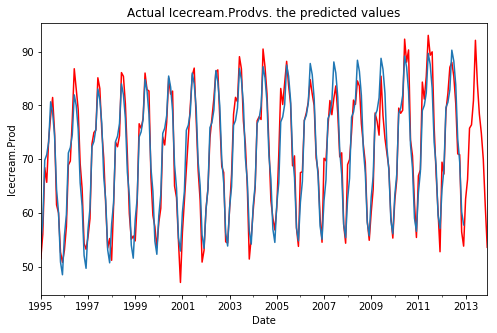

In [24]:
def plot_mod_fit(df, col):
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(8, 5)) # set plot area
    ax = fig.gca() # define axis  
    df.loc[:, col].plot(color = 'r', ax = ax)
    df.loc[:, 'scores'].plot(ax = ax) 
    ax.set_title('Actual ' + col + 'vs. the predicted values') # Give the plot a main title
    ax.set_xlabel('Date') # Set text for the x axis
    ax.set_ylabel(col)# Set text for y axis
plot_mod_fit(dairy, 'Icecream.Prod') 

In [25]:
def RMSE(ts, score):
    from math import sqrt
    return sqrt(np.std(ts - score))

## Make the forecast for the next year
X = dairy.loc['2012-12-31':, features].as_matrix()
RMSE(dairy.loc['2012-12-31':, 'Icecream.Prod'].as_matrix(), mod_fit.predict(X))

/Users/dusty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/dusty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


1.5276309485686628

In [26]:
def plot_ts(ts, lab = ''):
    ts.plot()
    plt.title('Time series plot of ' + lab)
    plt.ylabel('Value')
    plt.xlabel('Date')
    
def dist_ts(ts, lab = '', bins = 40):
    import scipy.stats as ss
    ## Setup a figure with two subplots side by side
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3))
    ## Plot the histogram with labels
    ts.hist(ax = ax1, bins = bins, alpha = 0.5)
    ax1.set_xlabel('Value')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Histogram of ' + lab)
    ## Plot the q-q plot on the other axes
    ss.probplot(ts, plot = ax2)

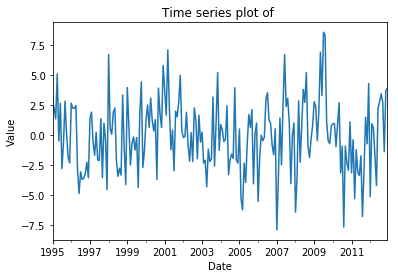

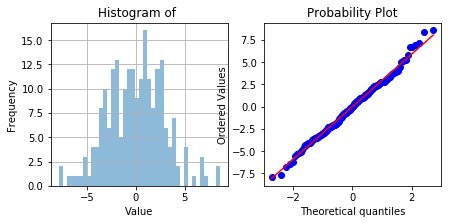

In [27]:
plot_ts(dairy.loc[:'2012-12-31', 'resids'])
dist_ts(dairy.loc[:'2012-12-31', 'resids'])

### Thoughts:
Over all this model predicted well with a low RMSE and normally distributed residuals.

### Next: Try using ARIMA

In [28]:
DF_Test(dairy.loc[:'2012-12-31', 'resids'])

D-F statistic = -3.606907715663305
p-value = 0.005630332009884346
number of lags used = 14
Critical value at 5% confidence = -2.876029332045744
Critical value at 10% confidence = -2.5744932593252643


In [29]:
BIC, order, model_fit = step_ARIMA(dairy.loc[:'2012-12-31', 'resids'], 3, 3, 3)    
print('Best order = ' + str(order) + ' best BIC = ' + str(BIC))

Testing model of order: (0, 0, 1) with BIC = 1075.7066859496347
Testing model of order: (0, 0, 2) with BIC = 1080.6342500295866
Testing model of order: (0, 0, 3) with BIC = 1059.457719702032
Testing model of order: (0, 1, 1) with BIC = 1078.9154480448046
Testing model of order: (0, 1, 3) with BIC = 1087.0582461322297
Testing model of order: (0, 2, 1) with BIC = 1169.53720727739
Testing model of order: (1, 0, 0) with BIC = 1073.6980510779074
Testing model of order: (1, 0, 1) with BIC = 1073.6518119213863
Testing model of order: (1, 0, 2) with BIC = 1078.3118349755634
Testing model of order: (1, 0, 3) with BIC = 1064.3453202359017
Testing model of order: (1, 1, 0) with BIC = 1120.8205124669664
Testing model of order: (1, 1, 1) with BIC = 1081.456933088868
Testing model of order: (1, 1, 2) with BIC = 1076.9341729511323
Testing model of order: (1, 1, 3) with BIC = 1082.286324765759
Testing model of order: (1, 2, 0) with BIC = 1290.7273586567705
Testing model of order: (1, 2, 3) with BIC = 

In [30]:
# Fit the model with the best order (lowest BIC)
BIC, order, model_fit = model_ARIMA_2(dairy.resids[:-12], order = (0,0,3))

Testing model of order: (0, 0, 3) with BIC = 1059.457719702032


In [31]:
# Make predictions for the year of 2013
start_index = len(dairy.loc[:'2012-12-31', 'resids'])
end_index = start_index + 12

model_prediction = model_fit.predict(start=start_index, end=end_index)

/Users/dusty/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:320: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  freq=base_index.freq)


In [32]:
## Make the forecast for the next year
X = dairy.loc['2012-12-31':, features].as_matrix()
## Find the residu
dairy.loc['2012-12-31':, 'scores'] =  mod_fit.predict(X) - model_prediction

/Users/dusty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [33]:
#dairy.loc[:, 'scores'] =  mod_fit.predict(X) - model_prediction

In [34]:
dairy['resids'] = dairy['scores'] - dairy['Icecream.Prod']
dairy.tail(12)

,Icecream.Prod,Month.Count,monthNumSqred,monthNumCubed,Month,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,scores,resids
2013-01-31,62.612,1.557341,1.905056,2.137089,Jan,0,0,0,0,1,0,0,0,0,0,0,0,57.508365,-5.103635
2013-02-28,66.274,1.572535,1.933008,2.179043,Feb,0,0,0,1,0,0,0,0,0,0,0,0,63.734321,-2.539679
2013-03-31,75.770,1.587729,1.961089,2.221384,Mar,0,0,0,0,0,0,0,1,0,0,0,0,67.691634,-8.078366
2013-04-30,76.396,1.602922,1.989299,2.264113,Apr,1,0,0,0,0,0,0,0,0,0,0,0,80.297218,3.901218
2013-05-31,80.899,1.618116,2.017637,2.307233,May,0,0,0,0,0,0,0,0,1,0,0,0,81.258721,0.359721
2013-06-30,92.091,1.633309,2.046103,2.350744,Jun,0,0,0,0,0,0,1,0,0,0,0,0,83.611310,-8.479690
2013-07-31,84.026,1.648503,2.074698,2.394649,Jul,0,0,0,0,0,1,0,0,0,0,0,0,90.974151,6.948151
2013-08-31,78.382,1.663696,2.103422,2.438950,Aug,0,1,0,0,0,0,0,0,0,0,0,0,88.953411,10.571411
2013-09-30,74.871,1.678890,2.132274,2.483648,Sep,0,0,0,0,0,0,0,0,0,0,0,1,84.529535,9.658535
2013-10-31,70.011,1.694084,2.161254,2.528745,Oct,0,0,0,0,0,0,0,0,0,0,1,0,74.554800,4.543800


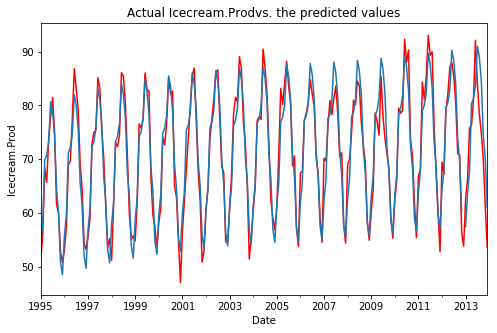

In [35]:
plot_mod_fit(dairy, 'Icecream.Prod') 

In [36]:
RMSE(dairy.loc['2012-12-31':, 'Icecream.Prod'].as_matrix(), dairy.loc['2012-12-31':, 'scores'])

/Users/dusty/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


2.5731859747208286

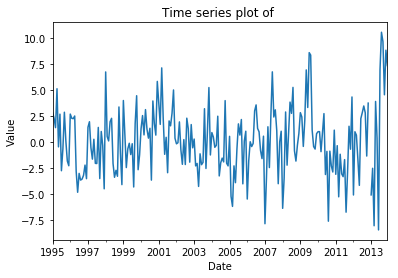

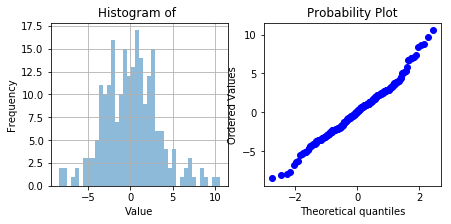

In [37]:
plot_ts(dairy['resids'])
dist_ts(dairy['resids'])

In [38]:
DF_Test(dairy.loc[:'2013-12-31', 'resids'].dropna(axis=0))

D-F statistic = -3.075189292516361
p-value = 0.028444613325672545
number of lags used = 14
Critical value at 5% confidence = -2.875271898983725
Critical value at 10% confidence = -2.5740891037735847


The residuals for the model produce a p-value of 0.03 for the DF test, so we resject the null hypothesis that the time series is not stationary.

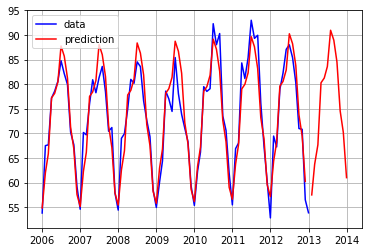

In [39]:
plt.plot(dairy.loc['2005-12-31':'2012-12-31','Icecream.Prod'], color='b', label = 'data')
plt.plot(dairy.loc['2005-12-31':, 'scores'], color='r', label = 'prediction')
plt.legend()
plt.grid()
plt.show()

Here is a plot of the data and predictions:
We can see they line up very closely, and the prediction for the year of 2013 looks reasonable.  I will use this model.

In [40]:
# Calculate the CI for the predictions in the past and the future.
import numpy as np, scipy.stats as st
dairy = dairy.dropna(axis=0)
future_ci = st.t.interval(0.95, len(dairy['scores'])-1, loc=np.mean(dairy.loc['2013-01-01':, 'scores']), scale=st.sem(dairy.loc['2013-01-01':,'scores']))
past_ci = st.t.interval(0.95, len(dairy['scores'])-1, loc=np.mean(dairy.loc[:'2013-01-01', 'scores']), scale=st.sem(dairy.loc[:'2013-01-01','scores']))
all_ci = st.t.interval(0.95, len(dairy['scores'])-1, loc=np.mean(dairy.loc[:, 'scores']), scale=st.sem(dairy.loc[:,'scores']))

In [41]:
print('future_ci: ', future_ci)
print('future mean: ', np.mean(dairy.loc['2013-01-01':, 'scores']))
print('past_ci: ', past_ci)
print('past mean: ', np.mean(dairy.loc[:'2013-01-01', 'scores']))
print('all_ci: ', all_ci)
print('all mean: ', np.mean(dairy.loc[:, 'scores']))

future_ci:  (68.98025799660934, 81.74721126891956)
future mean:  75.36373463276445
past_ci:  (69.7366553343546, 72.63040901799604)
past mean:  71.18353217617532
all_ci:  (69.99122391725871, 72.8178001661851)
all mean:  71.4045120417219


### Results:

The CI are reasonable small compared to the mean.  When considering all of the data, the mean is 71.4, and the CI is roughly +- 1.4.  However this changes when we just look at future preditions.

### 2.  How do the confidence intervals behave as time moves to the future?

### Results:

When looking at just the future results, we can see that the CI is significantly larger.  The 95% confidence interval for the past is 71.2 +- 1.5 roughly.  For the future predictions, it's 75.4 +- 6.4.  I think this is predictable because our predictions should get less and less accurate the further from actual data (timewise) we get.  We can also observe the residuals, and see there is a sharp spike in magnitude once the furture is reached.  Overall this model predicts the production of ice cream relatively well, but coult be better.